# Analyzing 30-Year Average Daily Sea Level Pressure Data


## Introduction

My main motivation for this project is the research I am currently doing in the Climate Science Lab at PSU. I am working with Dr. Loikith to understand the meteorology driving poor air quality in Portland. We have been focused on understanding the meterological conditions associated with high PM2.5 concentrations in Portland's wood burning season, which is from October to February. This is important because Portland is prone to surface-based inversions and air stagnation, leading to historically high PM2.5 concentrations, specifically during the wood burning season. 

So, far we have looked at wind speed, temperature, and pressure gradient force to understand the drivers of high PM2.5 concentrations. We found that weak pressure gradients, calm winds, and surface-based inversion are meteorological conditions that create an environment that is more prone to air stagnation, resulting in high PM2.5 concentrations in Portland, Oregon. The stable lower atmosphere leads to a lack of vertical mixing and the wood smoke pollution remains near the surface.

The next step in our research is to look at large-scale meteorology associated with PM2.5 events. We will use sea level pressure data to determine if there are any trends in days with high PM2.5 concentrations.

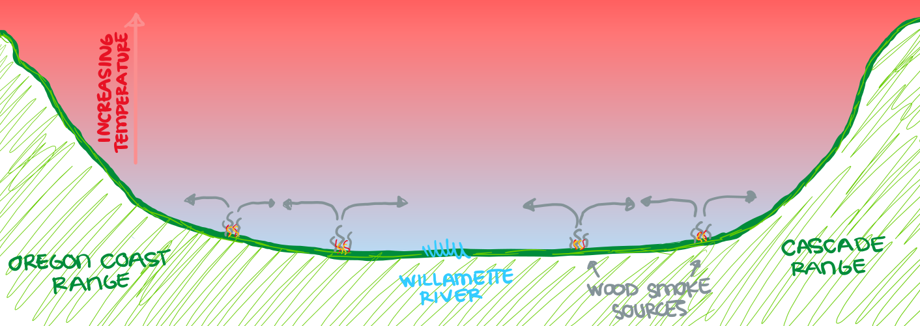
    **Figure 1.** Representation of a surface-based inversion in the Willamette Valley trapping air near the surface.

## Methods

In this project, ERA-5 climate reanalysis data is used to determine the daily average sea level pressure. 30 years of data for each day is used to calculate the average sea level pressure for the months of November through February*. 

The average sea level pressure over Portland is then analyzed. Discrete Cosine Transform (DCT) coefficients are calculated and plotted to observe patterns in the data. Then the sea level pressure data will be smoothed by keeping the top 2% of DCT coefficients.

Sea Level Pressure on hours with high PM2.5 concentrations are then calculated. The average sea level pressure for hours with PM2.5 concentration greater than 11.9 $\mu m$ is calculated and plotted using MATLAB. 

The numerical methods used in this project are opening and combining netcdf files, calcualting discrete cosine transforms, and creating density plots. 

**Four consecutive months were available to our research group, but this code should be re-run for a whole year's worth of data when downloaded.*

## Code
### Calculating the 30-Year Average Daily Sea Level Pressure from ERA-5 Data

In [ ]:
import netCDF4 as nc
import numpy as np
import os

#set new directory
os.chdir('I:\\ERA5\\SLP')

#define days in each month
#nov,dec,jan,feb
days = [30,31,31,28]

#count the number of days calculated
i = 0

#define lengths of arrays
yrs = 30
latlength = 721
lonlength = 1440

#create arrays to store data
slpaverages = np.zeros([124,latlength,lonlength])

#loop through each month
#four months
for a in range(0,4):
    #define folder where files are located
    if a == 0:
        filefolder = 'ERA5_*11_SLP_day.nc'
    if a == 1:
        filefolder = 'ERA5_*12_SLP_day.nc'
    if a == 2:
        filefolder = 'ERA5_*01_SLP_day.nc'
    if a == 3:
        filefolder = 'ERA5_*02_SLP_day.nc'
        
    #create combined dataset of files
    myfiles = nc.MFDataset(filefolder)

    #print metadata of files
    print(myfiles)

    #print dimensions and variables of files
    for dim in myfiles.dimensions.values():
        print(dim)
    for var in myfiles.variables.values():
        print(var)
    
    #redefine names of variables
    time = myfiles.variables['time']
    lat = myfiles.variables['latitude']
    long = myfiles.variables['longitude']
    slp = myfiles.variables['msl']
    
    #create arrays to store data
    slptemp = np.zeros([yrs,len(lat),len(long)])
    timetemp = np.zeros([yrs,len(time)])

    #create loop to calculate average slp for each day of the month
    #set initial k equal to zero
    k = 0
    
    #loop through all days of the month
    while k < days[a]+1:
        for j in range(yrs):              
            #grab rows for day k of month
            dtime = time[k+days[a]*j] #31 for nov dec, 28 for feb
            dslp = slp[k+days[a]*j,:,:]
            #add info to temporary arrays    
            slptemp[j] = dslp
            timetemp[j] = dtime

        #calculate average daily slp of all years
        slpavg = np.mean(slptemp,axis=0)
        #reshape average from 2D to 3D
        slpavg = slpavg.reshape((1, slpavg.shape[0], slpavg.shape[1]))
        #add to array of averages
        slpaverages[i,:,:] = slpavg

        #increase k and i to go to next day
        i += 1
        k += 1
        
np.save('I:\\Emma\\Project\\dailyaveragesSLP1102.npy',slpaverages)

### Calculating the Discrete Cosine Transform and Smoothing SLP Data

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

#load in array of slp averages
slpavgs = np.load('I:\\Emma\\Project\\dailyaveragesSLP1102.npy')
print('done')

#change current directory to access dcst module
os.chdir('C:\\Users\\EmmaRuss\\Desktop\\PH 322\\Homework')
from dcst import dct,idct

#reduce lat and long to pdx, and slp data
nlat = 46
nlong = -123
slppdx = slpavgs[:,nlat,nlong]

#check size of array, should be 1D
print(slppdx.shape)

#calculate discrete cosine transform of data using dcst.dct function
dct = dct(slppdx)

plt.plot(abs(dct),color='orange')
plt.title('DCT')
plt.xlabel('k')
plt.ylabel(r'$\c_k$')
plt.ylim(0,100000)

#define everything other than top 2% as data we want to set to 0
remove = np.argwhere(abs(dct)<np.percentile(abs(dct),98))
dct[remove] = 0

#calculate the inverse discrete cosine transform, smoothed data
smoothedslp = idct(dct)

#plot original data set and smoothed dataset
plt.plot(slppdx,color='red')
plt.plot(smoothedslp,color='purple')
plt.title('Sea Level Pressure in Portland')
plt.xlabel('Days since 01 November')
plt.ylabel('Sea Level Pressure (Pa)')
plt.legend(['Original Data','Smoothed Data'])
plt.xlim(0,123)
plt.show()

### Plotting Average SLP for high PM2.5 Hours
#### Executed with MATLAB

In [ ]:
#%load file containing high pm2.5 data and slp
load('I:Emma\SLP Maps\ERA5\\HighPMYellowslp.mat')
gridfile='I:Emma\SLP Maps\ERA5\HighPMYellowslp.mat'

#%redefine variables from file
SLP=slp_high_pm;
gridlat=nlat;
gridlon=nlong;
time=time_high_pm;

#%reduce latitude and longitude to area of interest
latind = find(gridlat > 34.8 & gridlat < 55.501);
lonind = find(gridlon < -113.12);

#%redefine variables to include only reduced lat and long
gridlat = gridlat(latind);
gridlon = gridlon(lonind);
SLP = SLP(:,lonind,latind);

#%calculate the mean sea level pressure
mSLP = squeeze(mean(SLP));

#change order of variables, lat first. 
mSLP = permute(mSLP,[2,1]);

#%convert Pa to mb
mmSLP = mSLP/100;

#%create plot axis and create colormap
axesm('eqdcylin','MapLatLimit',[34.8 55.501],'MapLonLimit',[-145 -113.12])
pcolorm(gridlat,gridlon,mmSLP)

#%reduce lat and long limits
latlim=getm(gca,'MapLatLim');
lonlim=getm(gca,'MapLonLim');

#%generate states and canada boarders
states=shaperead('I:Emma\SLP Maps\ERA5\s_11au16.shp','UseGeoCoords',true,'BoundingBox',[lonlim',latlim']);
canada=shaperead('I:Emma\SLP Maps\ERA5\PROVINCE.SHP','UseGeoCoords',true,'BoundingBox',[lonlim',latlim']);
geoshow(gca,states,'EdgeColor',[0 0 0],'FaceAlpha',0)
geoshow(gca,canada,'EdgeColor',[0 0 0],'FaceAlpha',0)

#%create red point on portland
geoshow(45.6,-122.65,'DisplayType','Point','Marker','.','Color','red','MarkerSize',20)

#%generate contour lines, every 5 mb
contourm(gridlat,gridlon,mmSLP,'LineWidth',1,'LevelStep',5,'LineColor',[1 1 1])

#%remove white spacing and tighten map
tightmap
gridm on
framem on
mlabel('equator')
plabel(0)

#%define location and spacing of lat and long labels
setm(gca,'mlinelocation',5)
setm(gca,'plinelocation',5)
setm(gca,'mlabellocation',[-120 -130 -140])
setm(gca,'plabellocation',[40 50])

#%create colorbar
a=colorbar('WestOutside');
a.Label.String = 'Sea Level Pressure (mb)';
a.Limits = [1000 1025];
a.FontSize = 14;
a.FontWeight = 'bold';

## Results

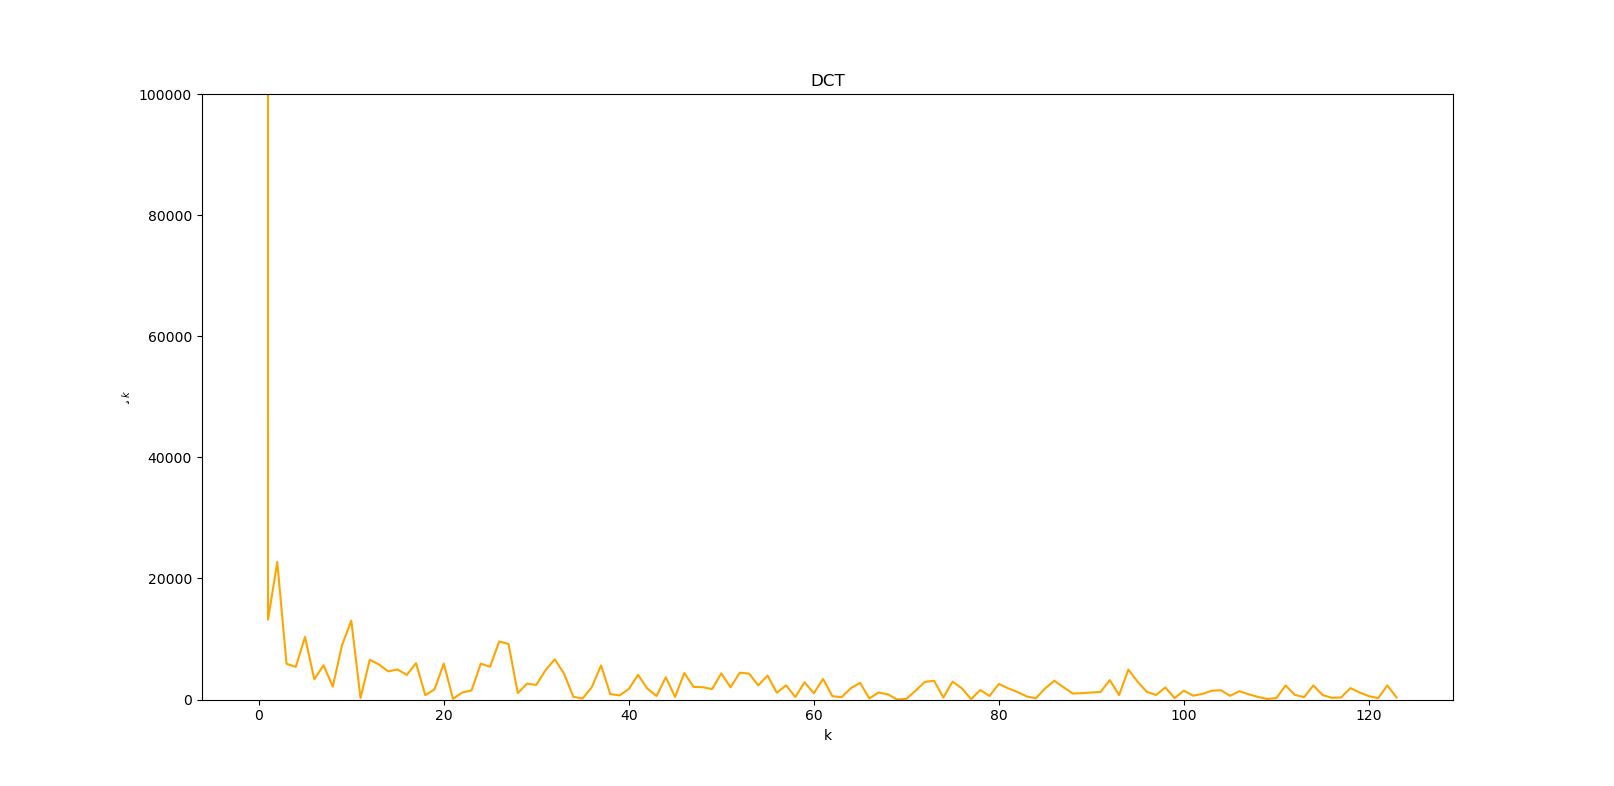
**Figure 2.** Discrete Cosine Transforms coefficients for 30-year average sea level pressure of Portland from 01 November to 28 February.

There is a large spike in the DCT coefficients at k = 0. This is just the sum of the data, and is not representative of any cosine behavior. There do not seem to be any other large coefficients that would show a cyclic pattern in the data. There is not a strong cosine pattern in the period of time analyzed.

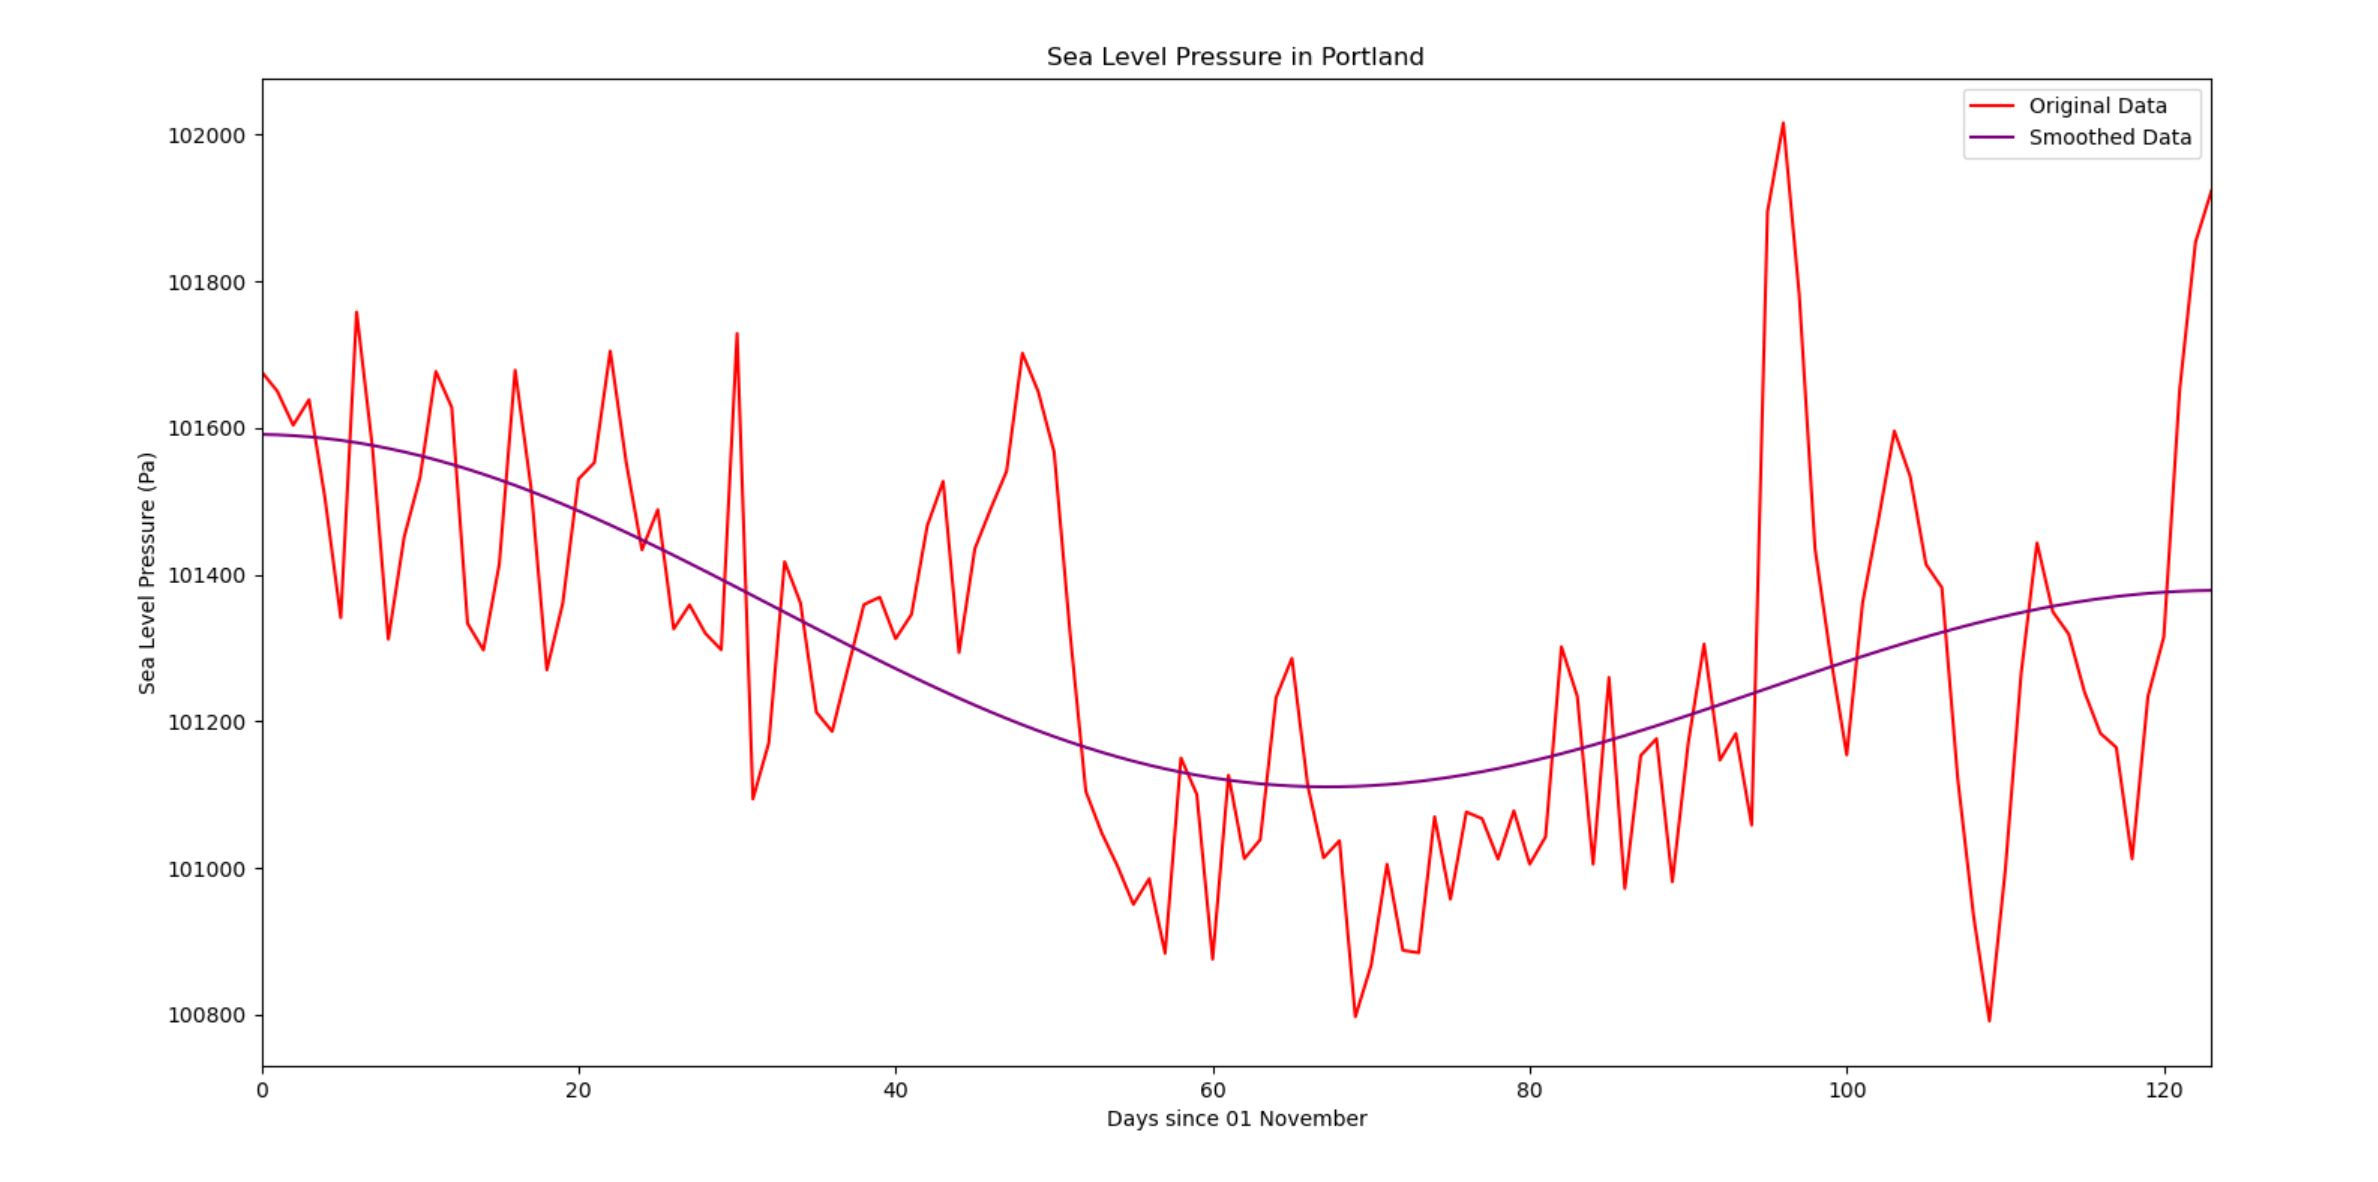
**Figure 3.** 30-year average sea level pressure from 01 November to 28 February. Original data is shown in red and smoothed data is shown in purple.

The smoothed data of the discrete cosine transform fits the original data quite well. However, large high sea level pressures are not represented as well as the amplitude of the cycles. The smoothed data has a lower amplitude than the cycles of the original data. This analysis would be more telling if a whole year of data was used to better match a long-term trend in the data.

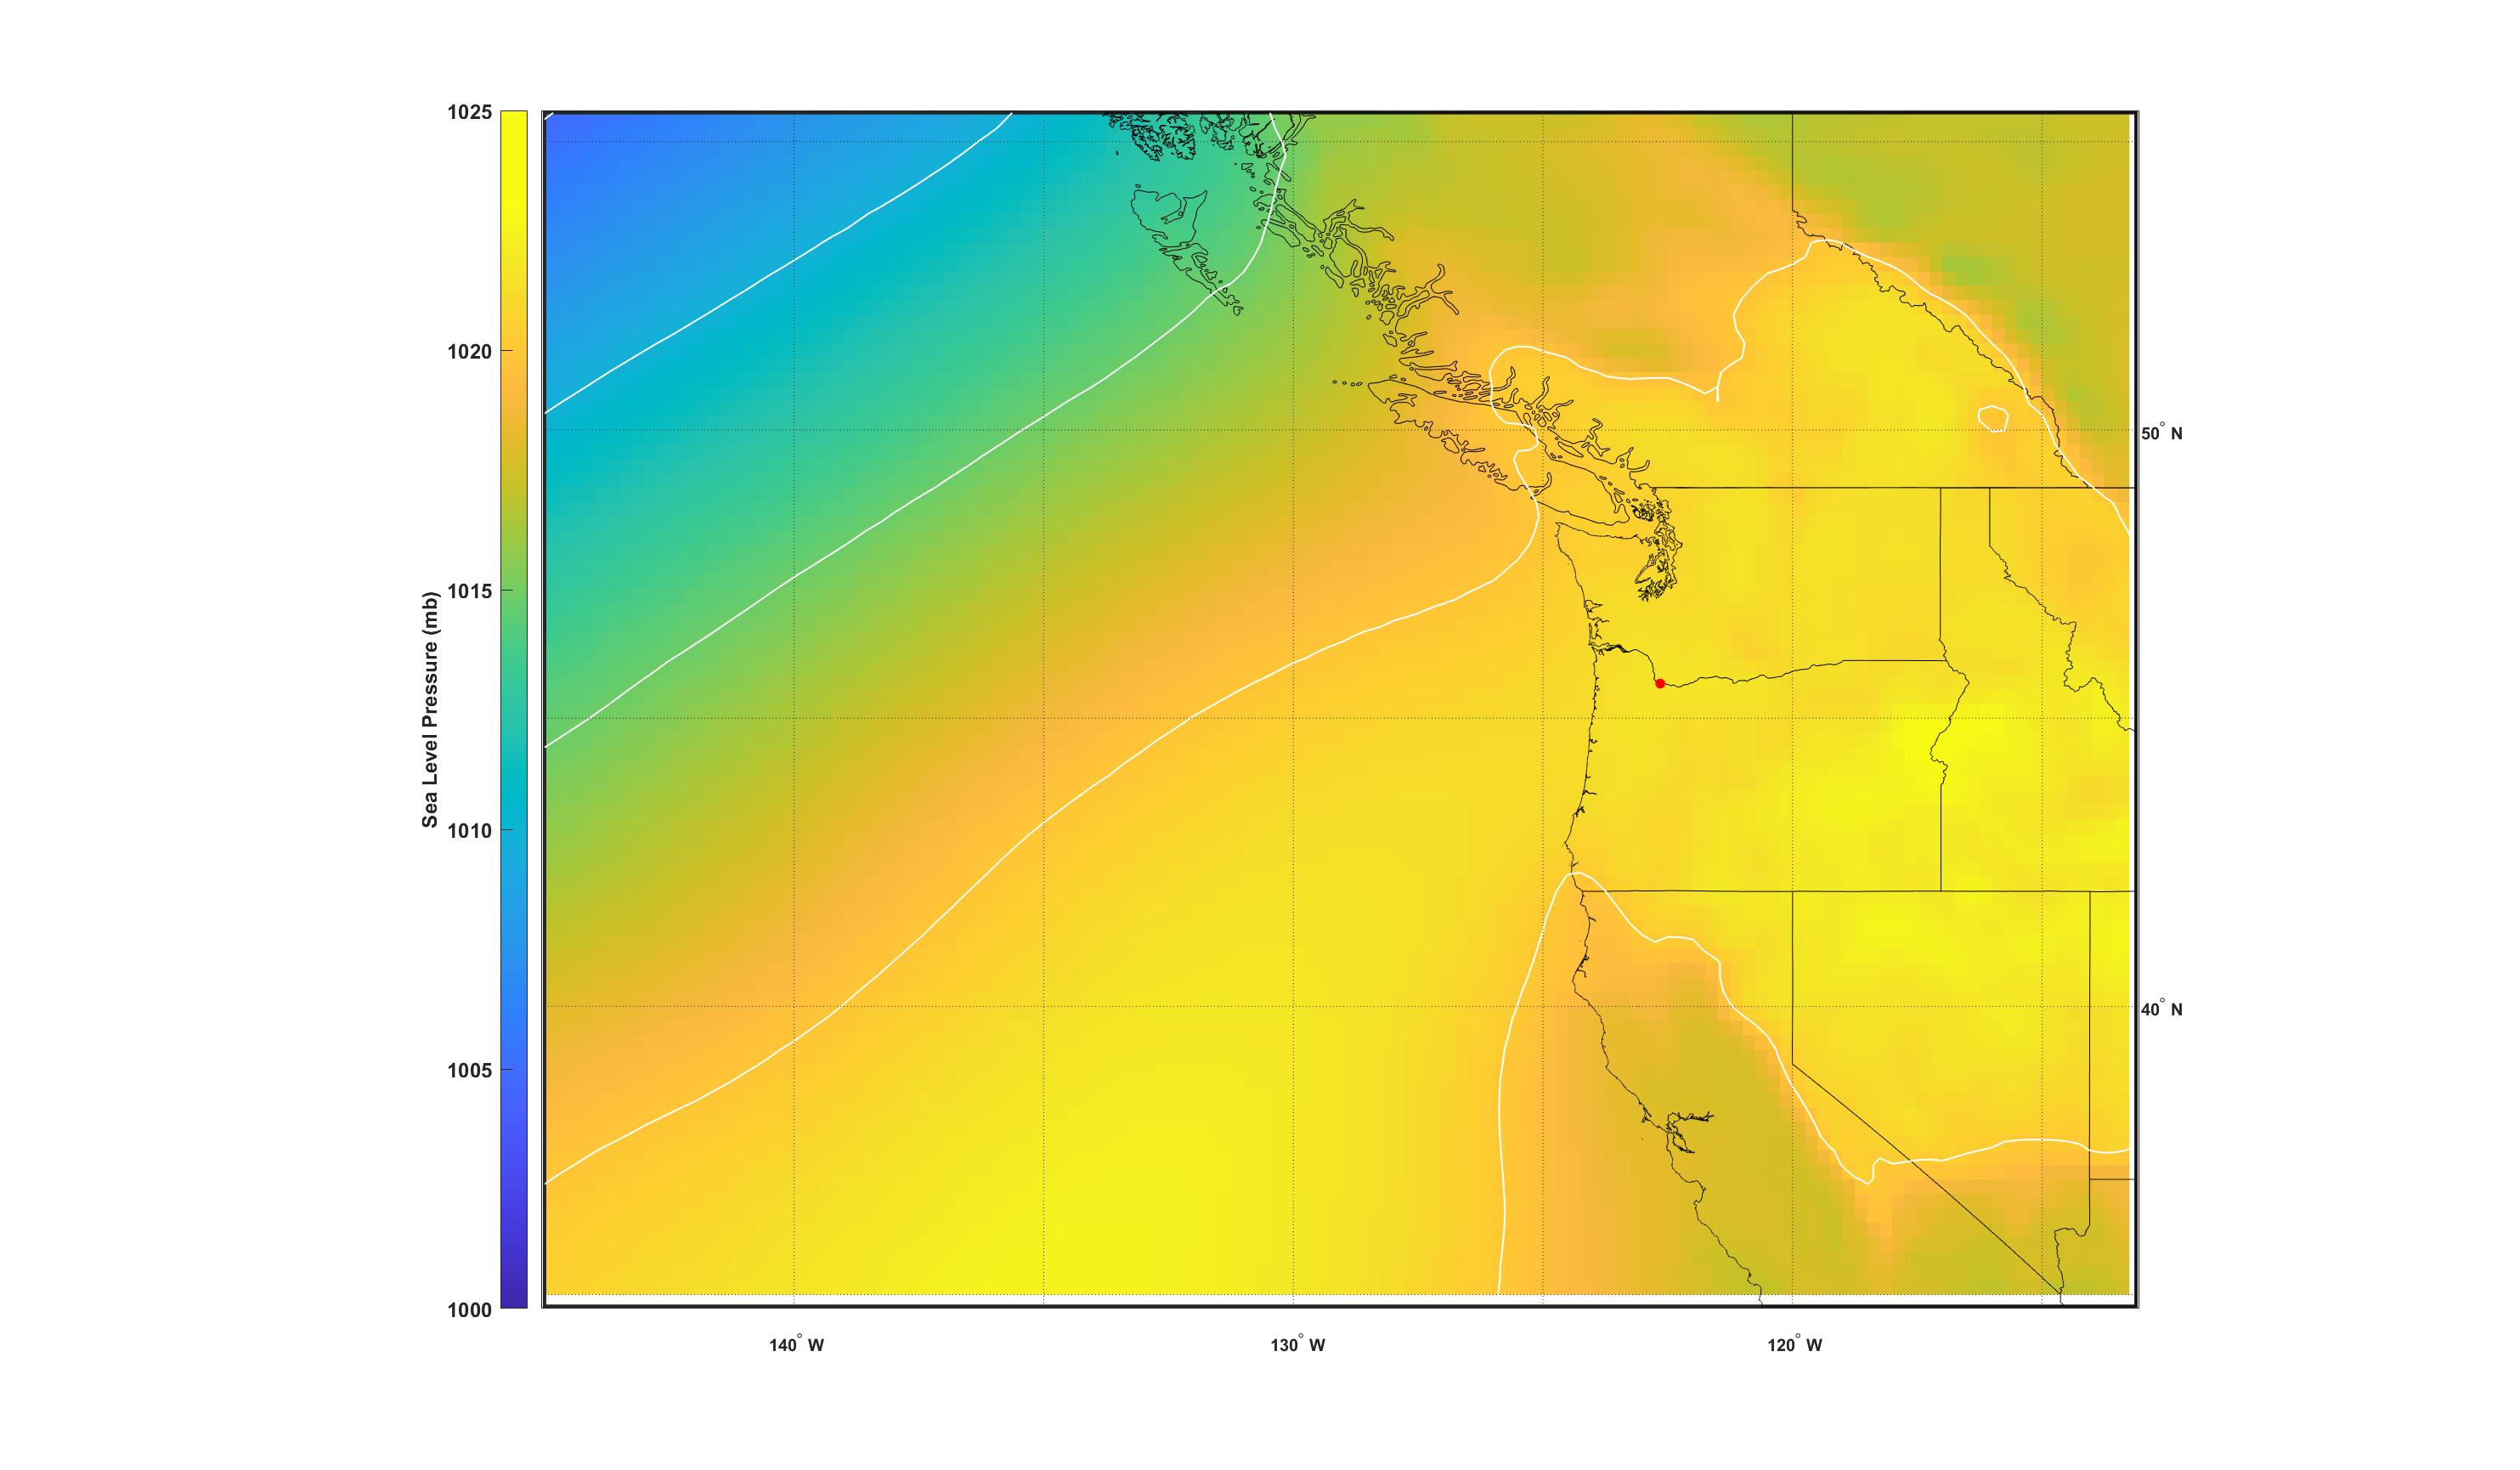
**Figure 4.** Average sea level pressure for hours with PM2.5 greater than 11.9 $\mu m$ from 1 October 2019 to 28 February 2020. 

The sea level pressure map shows a strong high pressure over Portland in a distinct upside-down v pattern. Lower pressure occurs in California and decreases over the Pacific. This pattern is to be expected as high pressure allows for a stable atmosphere and air stagnation.

## Conclusion

In conclusion, there wasn't a strong cyclical pattern to the data. The discrete cosine fourier smoothing reduced the amplitude of cycles of the data, and did not accurately represent spikes in sea level pressure. The same process should be done on a year's worth of 30-year averages. Because of the limitation on data in my research group, I only used four months of data. This code is easily adaptable to be used for more data, which is my next step in my research once that data is available.

There was a unique sea level pressure pattern for days with high PM2.5 concentrations in the 2019-2020 wood burning season. A high pressure system shaped in an upside-down v is centered over Portland. The purpose of calculating 30-year average sea level pressure is to calculate the sea level pressure anomalies of the 2019-2020 wood burning season high PM2.5 concentration sea level pressure. This measures how different the sea level pressure for hours with high PM2.5 is from the normal sea level pressure. This will help us understand how sea level pressure patterns contribute to high PM2.5 concentrations in Portland.